## Classify candlestick patterns

All patterns in https://thepatternsite.com/Candles2.html will be detected and classified into bullish/ bearish. Assume taking long/short positions at t=0candle accordingly with suitable stop loss/gain, calculate the profit earned at t=5, 10, 15, 20candles. Each candle represent a 1h or 4hr interval. 

In [1]:
import time
# import warnings
from datetime import datetime, timezone
from typing import List, Union
import requests
import pandas as pd
from price_data import BinanceAPI 
from matplotlib import pyplot as plt

bn = BinanceAPI()

Fetch data

In [2]:
btc_4h = pd.read_csv('./csv_files/btc_4h.csv', header=0).set_index('date_time')
eth_4h = pd.read_csv('./csv_files/eth_4h.csv', header=0).set_index('date_time')
# btc_4h = bn.get_kline(symbol = 'BTCUSDT', interval = '4h', instrument_type='spot',start_date = '2022-01-01 00:00:00', end_date='2023-12-31 23:59:59')
# btc_4h[['open', 'high', 'low', 'close', 'volume']
#        ] = btc_4h[['open', 'high', 'low', 'close', 'volume']].astype(float)

# eth_4h = bn.get_kline(symbol = 'ETHUSDT', interval = '4h', instrument_type='spot',start_date = '2022-01-01 00:00:00', end_date='2023-12-31 23:59:59')
# eth_4h[['open', 'high', 'low', 'close', 'volume']
#        ] = eth_4h[['open', 'high', 'low', 'close', 'volume']].astype(float)
# data_4h = [btc_4h, eth_4h]

# btc_4h.to_csv('./csv_files/btc_4h.csv')
# eth_4h.to_csv('./csv_files/eth_4h.csv')

In [23]:
btc_4h.dtypes

open_time                       float64
open                            float64
high                            float64
low                             float64
close                           float64
volume                          float64
close_time                        int64
quote_asset_volume              float64
number_of_trades                  int64
taker_buy_base_asset_volume     float64
taker_buy_quote_asset_volume    float64
ignore                            int64
dtype: object

Variable and mapping set up

In [45]:
# columns=['symbol_interval', 'gain_loss_ratio', 'pattern', 'exit_after','mean', 'Q0', 'Q1', 'Q2', 'Q3', 'Q4','skew', 'kurt']
metadata = pd.DataFrame([])
coin_sym_to_dict = {'BTCUSDT_4h': btc_4h, 'ETHUSDT_4h': eth_4h}
coin_sym_data= None

In [46]:
def compute_ret_limit_gainloss(signal, stop_loss, stop_gain, start_cand: int, exit_after: int):
  open_price = coin_sym_data['open'].iloc[start_cand]
  exit_price = None
  
  if signal == 'bull':  # long position
    for cand in range(start_cand, start_cand+exit_after):
      if coin_sym_data['low'].iloc[cand] <= stop_loss:
        exit_price = stop_loss
      elif coin_sym_data['high'].iloc[cand] >= stop_gain:
        exit_price = stop_gain
    exit_price = coin_sym_data['close'].iloc[start_cand+exit_after-1]
    profit = exit_price - open_price
    return  profit/open_price
  
  elif signal == 'bear': # short position
    for cand in range(start_cand, start_cand+exit_after):
      if coin_sym_data['high'].iloc[cand] >= stop_loss:
        exit_price = stop_loss
      elif coin_sym_data['low'].iloc[cand] <= stop_gain:
        exit_price = stop_gain
    exit_price = coin_sym_data['close'].iloc[start_cand+exit_after-1]
    profit = open_price - exit_price
    return profit/open_price
  
  return None


def compute_ret(signal, stop_loss, stop_gain, start_cand: int, exit_after: int):
  open_price = coin_sym_data['open'].iloc[start_cand]
  exit_price = coin_sym_data['close'].iloc[start_cand+exit_after-1]

  if signal == 'bull':  # long position
    return exit_price/open_price -1.0
  elif signal == 'bear':  # short position
    return 1.0 - exit_price/open_price

  return None

In [64]:
def above_the_stomach(i, gain_loss_ratio) -> Union[dict, None]:
  conditions = [
                coin_sym_data['open'].iloc[i-5] > coin_sym_data['close'].iloc[i-5],
                coin_sym_data['open'].iloc[i-4] > coin_sym_data['close'].iloc[i-4],
                coin_sym_data['open'].iloc[i-3] > coin_sym_data['close'].iloc[i-3],
                coin_sym_data['open'].iloc[i-2] > coin_sym_data['close'].iloc[i-2],
                coin_sym_data['open'].iloc[i-1] < coin_sym_data['close'].iloc[i-1],
                coin_sym_data['open'].iloc[i] >= (coin_sym_data['open'].iloc[i-2] + coin_sym_data['close'].iloc[i-2])/2]
  if not all(conditions): 
    return None, None, None
  print(i)
  stop_loss = coin_sym_data['low'].iloc[i-2] * .9995
  stop_gain = (coin_sym_data['close'].iloc[i-1] - stop_loss) * \
      gain_loss_ratio + coin_sym_data['close'].iloc[i-1]
  return 'bull', stop_loss, stop_gain


def below_the_stomach(i, gain_loss_ratio) -> Union[dict, None]:
  conditions = [coin_sym_data['open'].iloc[i-5] < coin_sym_data['close'].iloc[i-5],
                coin_sym_data['open'].iloc[i-4] < coin_sym_data['close'].iloc[i-4],
                coin_sym_data['open'].iloc[i-3] < coin_sym_data['close'].iloc[i-3],
                coin_sym_data['open'].iloc[i-2] < coin_sym_data['close'].iloc[i-2],
                coin_sym_data['open'].iloc[i-1] > coin_sym_data['close'].iloc[i-1],
                coin_sym_data['open'].iloc[i] <= (coin_sym_data['open'].iloc[i-2] + coin_sym_data['close'].iloc[i-2])/2]
  if not all(conditions):
    return None, None, None
  # print(i)
  stop_loss = coin_sym_data['high'].iloc[i-2] * 1.0005
  stop_gain = coin_sym_data['close'].iloc[i-1]- (stop_loss - coin_sym_data['close'].iloc[i-1] ) * gain_loss_ratio 
  return 'bear', stop_loss, stop_gain


def dark_cloud_cover(i, gain_loss_ratio) -> Union[dict, None]:
  conditions = [coin_sym_data['open'].iloc[i-5] < coin_sym_data['close'].iloc[i-5],
                coin_sym_data['open'].iloc[i -4] < coin_sym_data['close'].iloc[i-4],
                coin_sym_data['open'].iloc[i -3] < coin_sym_data['close'].iloc[i-3],
                coin_sym_data['open'].iloc[i -2] < coin_sym_data['close'].iloc[i-2],
                coin_sym_data['open'].iloc[i -1] > coin_sym_data['close'].iloc[i-1],
                coin_sym_data['high'].iloc[i -1] > coin_sym_data['high'].iloc[i-2],
                coin_sym_data['close'].iloc[i-1] <= (coin_sym_data['open'].iloc[i-2] + coin_sym_data['close'].iloc[i-2])/2]
  if not all(conditions):
    return None, None, None
  # print(i)
  stop_loss = coin_sym_data['high'].iloc[i-2] * 1.0005
  stop_gain = coin_sym_data['close'].iloc[i-1] - \
      (stop_loss - coin_sym_data['close'].iloc[i-1]) * gain_loss_ratio
  return 'bear', stop_loss, stop_gain

In [65]:
patterns_lib = {'above_the_stomach': above_the_stomach,
                'below_the_stomach': below_the_stomach, 'dark_cloud_cover': dark_cloud_cover}

In [66]:
def detect_pattern_compute_stat(symbol_interval: str, pattern: str, exist_after, gain_loss_ratio=3) -> pd.DataFrame:

  df = []
  for i in range(5, len(coin_sym_data.index)-exist_after):
    signal, stop_loss, stop_gain = patterns_lib[pattern](
        i, gain_loss_ratio=gain_loss_ratio)
    # print(i)
    if signal == None:
      continue
    ret = compute_ret(signal=signal, stop_loss=stop_loss,
                      stop_gain=stop_gain, start_cand=i, exist_after=exist_after)
    df.append({'time': coin_sym_data.index[i], 'signal': signal, 'ret': ret})
  
  
  # display(df)
  df = pd.DataFrame(df).set_index('time')
  quantiles = list(df['ret'].quantile([0, .25, .5, .75, 1]))
  skew = df['ret'].skew()
  kurt = df['ret'].kurt()

  fig, graph = plt.subplots()
  graph.hist(df['ret'].sort_values(ignore_index=True),
             bins=int(len(df.index)*2/3))
  plt.ylabel('Frequency')
  plt.title(
      f'{symbol_interval}_gainlossratio={gain_loss_ratio}_pattern={pattern}_exist_after {exist_after/6}d')
  plt.xlabel(
      f'q0-4={[ round(q, 5) for q in quantiles]}\nskew={skew:.5f}_kurt={kurt:5f}')
  plt.savefig(
      f"./imagelib/{symbol_interval}_gain_loss_ratio={gain_loss_ratio}_pattern={pattern}_exist_after {exist_after/6}d candles.png")
  # display(graph)
  return pd.DataFrame([{'symbol_interval': symbol_interval,
                      'gain_loss_ratio': gain_loss_ratio,
                        'pattern': pattern,
                        'exist_after': exist_after,
                        'count': len(df.index),
                        'mean': df['ret'].mean(),
                        'Q0': quantiles[0],
                        'Q1': quantiles[1],
                        'Q2': quantiles[2],
                        'Q3': quantiles[3],
                        'Q4': quantiles[4],
                        'skew': skew,
                        'kurt': kurt}])

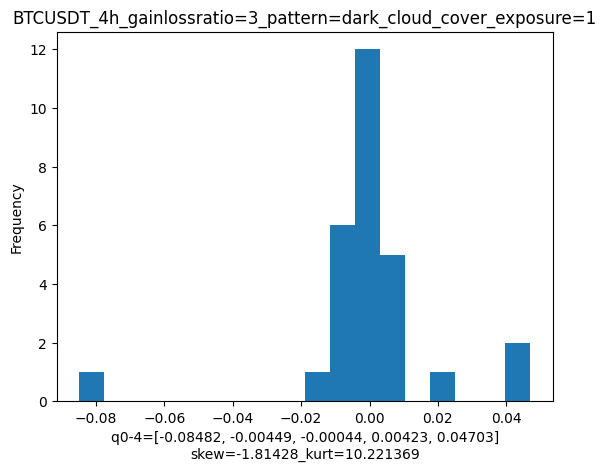

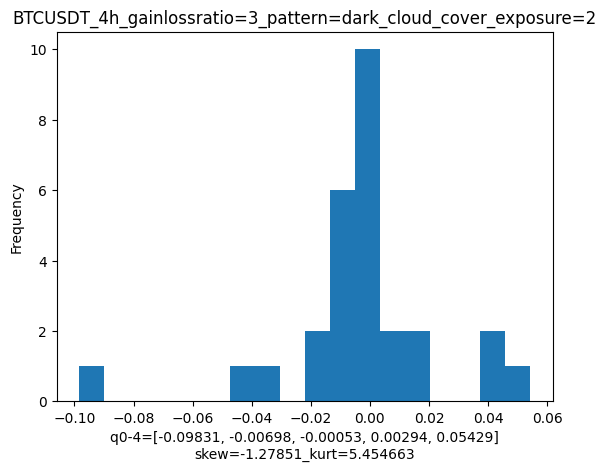

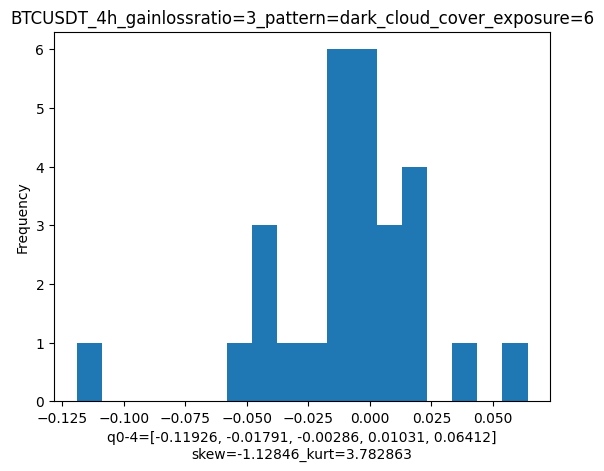

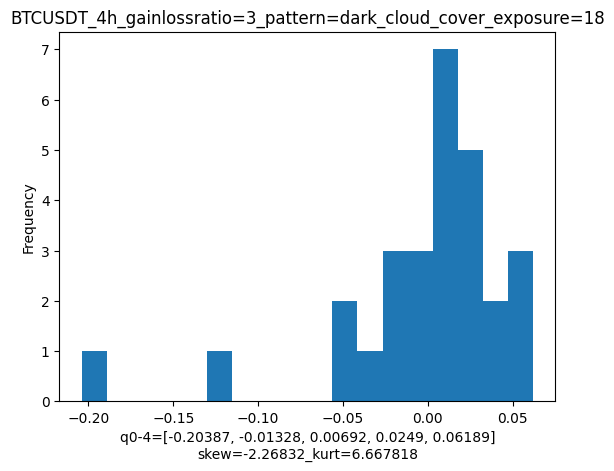

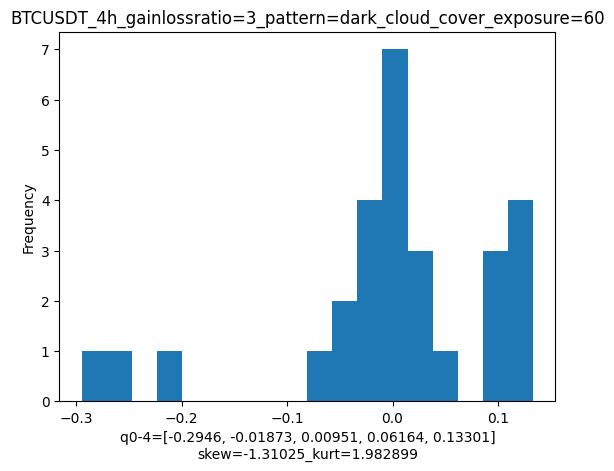

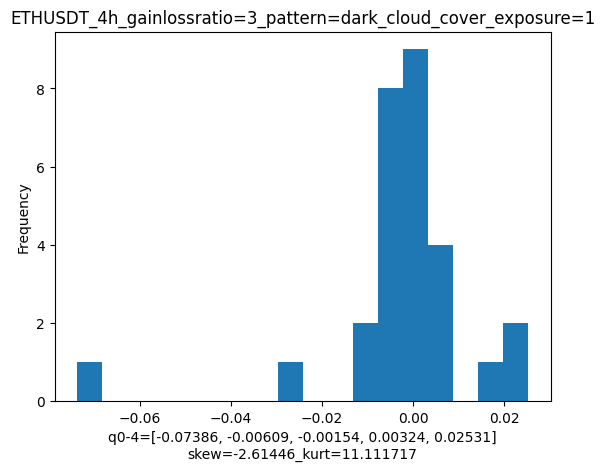

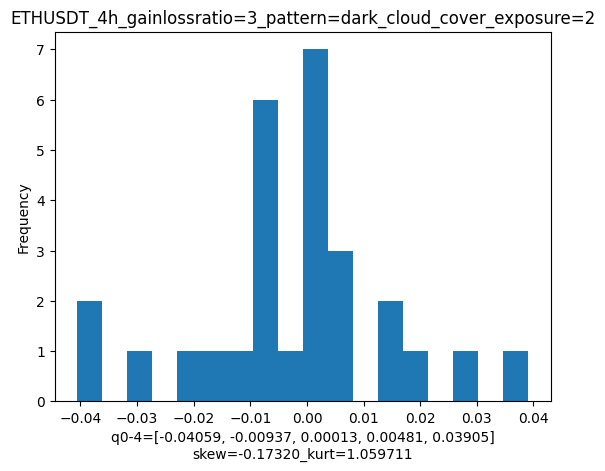

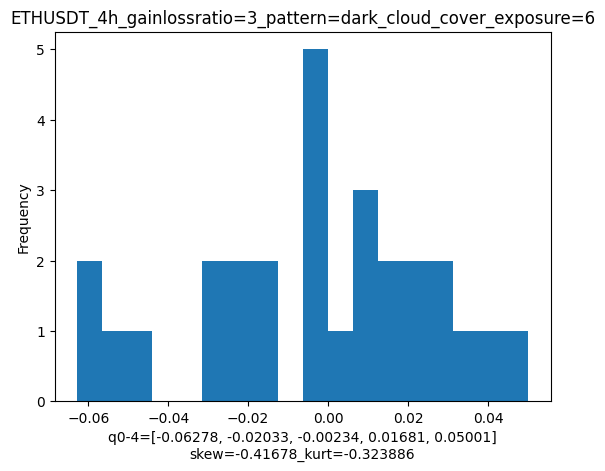

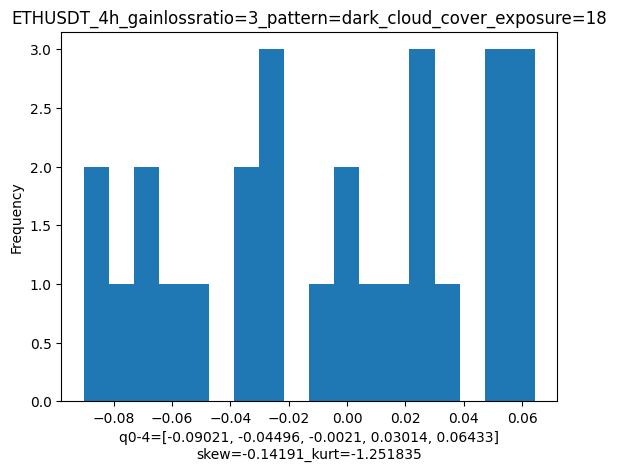

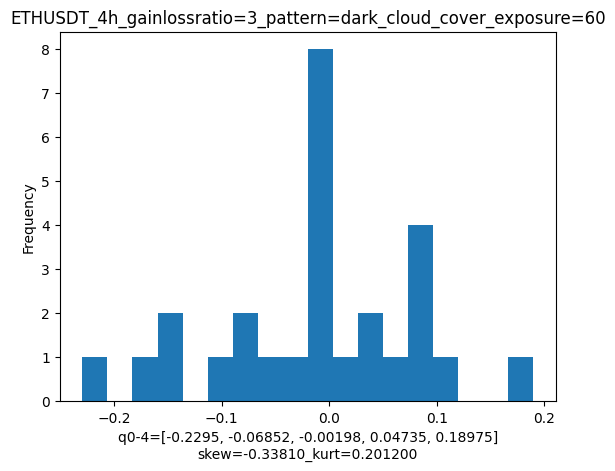

In [67]:
# global coin_sym_data
for this_coin_sym in ['BTCUSDT_4h','ETHUSDT_4h']:
  coin_sym_data = coin_sym_to_dict[this_coin_sym]
  for pattern in ['dark_cloud_cover']:
    
    pattern_detected_at = [] # some detector function
    
    exit_afters = [d*6 for d in [1,3,5,7,14,30]]
    for exit_after in exit_afters:
      metadata_row = detect_pattern_compute_stat(
          symbol_interval=this_coin_sym, pattern=pattern, exit_after=exit_after, gain_loss_ratio=3)
      metadata = pd.concat([metadata, metadata_row])

assume 0.0015 tx cost

In [68]:
metadata

,symbol_interval,gain_loss_ratio,pattern,exposure,count,mean,Q0,Q1,Q2,Q3,Q4,skew,kurt
0,BTCUSDT_4h,3,above_the_stomach,1,74,-0.000308,-0.044334,-0.005434,-0.000670,0.005716,0.045264,-0.098731,3.458514
0,BTCUSDT_4h,3,above_the_stomach,2,74,-0.000975,-0.042270,-0.005989,-0.000402,0.006004,0.044367,-0.222643,2.149768
0,BTCUSDT_4h,3,above_the_stomach,6,74,0.001850,-0.094180,-0.006740,0.000401,0.014408,0.084509,-0.073542,3.283877
0,BTCUSDT_4h,3,above_the_stomach,18,74,0.010651,-0.094359,-0.010738,0.003935,0.027630,0.198789,1.057393,4.007085
0,ETHUSDT_4h,3,above_the_stomach,1,79,-0.000937,-0.077568,-0.005478,-0.000709,0.004274,0.032140,-1.658494,8.999523
0,ETHUSDT_4h,3,above_the_stomach,2,79,-0.001010,-0.056102,-0.010479,-0.002579,0.008531,0.084272,0.726955,3.616790
0,ETHUSDT_4h,3,above_the_stomach,6,79,0.003886,-0.121380,-0.014601,0.001631,0.014344,0.128782,0.423201,2.645604
0,ETHUSDT_4h,3,above_the_stomach,18,79,0.001684,-0.296790,-0.024772,-0.004722,0.030043,0.193316,-0.192340,4.074591
0,BTCUSDT_4h,3,below_the_stomach,1,89,-0.001052,-0.084820,-0.004962,-0.000535,0.002343,0.047028,-1.887203,18.918287
0,BTCUSDT_4h,3,below_the_stomach,2,89,-0.003522,-0.098309,-0.006782,-0.002186,0.002730,0.054291,-1.147225,7.720741


In [61]:
# this_coin_sym = 'BTCUSDT'
# pattern = 'above_the_stomach'
# exit_after = 18

# detect_pattern_compute_stat(
#     symbol_interval=this_coin_sym, pattern=pattern, exit_after=exit_after, gain_loss_ratio=3)

In [73]:
# !!!!!!!!!Sepearate detect patterns and compute ret